In [1]:
import os
import numpy as np
import pandas as pd

# read csv file of data set
dataset = pd.read_csv("/Users/alirezashoja/Documents/GitHub/Machine-Failure-Prediction/Machine-Failure-Dataset.csv")
# show first rows of data set
dataset.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [3]:
# Explore the data set
print(dataset.isnull().sum())

# view basic statistics
print(dataset.describe())

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64
               UDI  Air temperature [K]  Process temperature [K]  \
count  10000.00000         10000.000000             10000.000000   
mean    5000.50000           300.004930               310.005560   
std     2886.89568             2.000259                 1.483734   
min        1.00000           295.300000               305.700000   
25%     2500.75000           298.300000               308.800000   
50%     5000.50000           300.100000               310.100000   
75%     7500.25000           301.500000               311.100000   
max    10000.00000           304.5000

In [5]:
from sklearn.preprocessing import MinMaxScaler
# Select features for normalization
features = ['Process temperature [K]','Torque [Nm]', 'Tool wear [min]']
target = 'Machine failure'

# Normalize features

scaler = MinMaxScaler()
dataset[features] = scaler.fit_transform(dataset[features])


In [6]:
#Check normalized Values

dataset[features].head()

,Process temperature [K],Torque [Nm],Tool wear [min]
0,0.358025,0.535714,0.000000
1,0.370370,0.583791,0.011858
2,0.345679,0.626374,0.019763
3,0.358025,0.490385,0.027668
4,0.370370,0.497253,0.035573


In [7]:
# Split data to test and train dataset

from sklearn.model_selection import train_test_split

# Split data

X = dataset[features]
Y = dataset[target]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.2, random_state=42 , stratify=Y )

In [85]:
# Train Models

# 1. Random Forest

from sklearn.ensemble import RandomForestClassifier

# Initialize and train Random Forest Model

rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight= "balanced", min_samples_split=5, min_samples_leaf=10, max_depth=10)
rf.fit(X_train, Y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=10, min_samples_split=5,
                       random_state=42)

In [86]:
# 2. Logistic Regression

from sklearn.linear_model import LogisticRegression

# Initialize and train Logistic Regression Model

lr = LogisticRegression(random_state=42, class_weight= "balanced")
lr.fit(X_train, Y_train)


LogisticRegression(class_weight='balanced', random_state=42)

In [87]:
# Predictions of random forest model
Y_pred_rf = rf.predict(X_test)
# Generate prediction for training data
Y_pred_rf_train = rf.predict(X_train)

# Predictions of logistic regression model
Y_pred_lr = lr.predict(X_test)

# Generate prediction for training data
Y_pred_lr_train = lr.predict(X_train)

In [88]:
# Evaluate Models
from sklearn.metrics import confusion_matrix, classification_report

# Concfusion Matrix and Classification Report of for Trainig data set Random Forest Model
cm_rf_train = confusion_matrix(Y_train, Y_pred_rf_train)
print("Random Forest Confusion Matrix: \n", cm_rf_train)
cr_rf_train = classification_report(Y_train, Y_pred_rf_train)
print("Random Forest Classification Report: \n", cr_rf_train)


Random Forest Confusion Matrix: 
 [[7113  616]
 [  11  260]]
Random Forest Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.92      0.96      7729
           1       0.30      0.96      0.45       271

    accuracy                           0.92      8000
   macro avg       0.65      0.94      0.71      8000
weighted avg       0.97      0.92      0.94      8000



In [89]:
# Concfusion Matrix and Classification Report of for Test data set Random Forest Model
cm_rf = confusion_matrix(Y_test, Y_pred_rf)
print("Random Forest Confusion Matrix: \n", cm_rf)
cr_rf = classification_report(Y_test, Y_pred_rf)
print("Random Forest Classification Report: \n", cr_rf)

Random Forest Confusion Matrix: 
 [[1774  158]
 [  15   53]]
Random Forest Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.92      0.95      1932
           1       0.25      0.78      0.38        68

    accuracy                           0.91      2000
   macro avg       0.62      0.85      0.67      2000
weighted avg       0.97      0.91      0.93      2000



In [90]:
# Confusion Matrix and Classification Report of for Trainig data set Logistic Regression Model
cm_lr_train = confusion_matrix(Y_train, Y_pred_lr_train)
print("Logistic Regression Confusion Matrix: \n", cm_lr_train)
cr_lr_train = classification_report(Y_train, Y_pred_lr_train)
print("Logistic Regression Classification Report: \n", cr_lr_train)


Logistic Regression Confusion Matrix: 
 [[5629 2100]
 [  72  199]]
Logistic Regression Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.73      0.84      7729
           1       0.09      0.73      0.15       271

    accuracy                           0.73      8000
   macro avg       0.54      0.73      0.50      8000
weighted avg       0.96      0.73      0.82      8000



In [91]:
# Confusion Matrix and Classification Report of for Test data set Logistic Regression Model
cm_lr = confusion_matrix(Y_test, Y_pred_lr)
print("Logistic Regression Confusion Matrix: \n", cm_lr)
cr_lr = classification_report(Y_test, Y_pred_lr)
print("Logistic Regression Classification Report: \n", cr_lr)


Logistic Regression Confusion Matrix: 
 [[1412  520]
 [  14   54]]
Logistic Regression Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.73      0.84      1932
           1       0.09      0.79      0.17        68

    accuracy                           0.73      2000
   macro avg       0.54      0.76      0.50      2000
weighted avg       0.96      0.73      0.82      2000



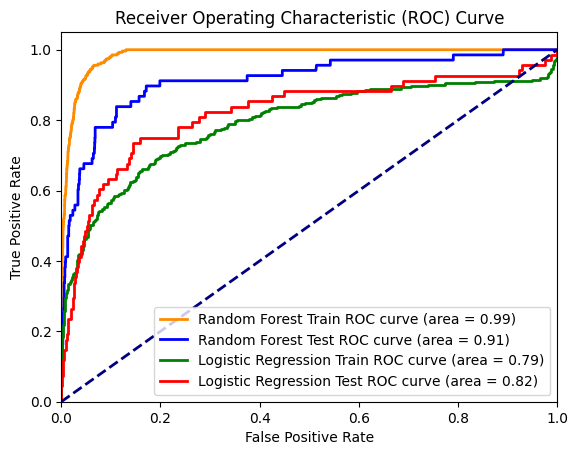

In [92]:
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for Random Forest
fpr_rf_train, tpr_rf_train, _ = roc_curve(Y_train, rf.predict_proba(X_train)[:, 1])
roc_auc_rf_train = auc(fpr_rf_train, tpr_rf_train)

fpr_rf_test, tpr_rf_test, _ = roc_curve(Y_test, rf.predict_proba(X_test)[:, 1])
roc_auc_rf_test = auc(fpr_rf_test, tpr_rf_test)

# Compute ROC curve and ROC area for Logistic Regression
fpr_lr_train, tpr_lr_train, _ = roc_curve(Y_train, lr.predict_proba(X_train)[:, 1])
roc_auc_lr_train = auc(fpr_lr_train, tpr_lr_train)

fpr_lr_test, tpr_lr_test, _ = roc_curve(Y_test, lr.predict_proba(X_test)[:, 1])
roc_auc_lr_test = auc(fpr_lr_test, tpr_lr_test)

# Plot ROC curves
plt.figure()

# Plot ROC for Random Forest
plt.plot(fpr_rf_train, tpr_rf_train, color='darkorange', lw=2, label='Random Forest Train ROC curve (area = %0.2f)' % roc_auc_rf_train)
plt.plot(fpr_rf_test, tpr_rf_test, color='blue', lw=2, label='Random Forest Test ROC curve (area = %0.2f)' % roc_auc_rf_test)

# Plot ROC for Logistic Regression
plt.plot(fpr_lr_train, tpr_lr_train, color='green', lw=2, label='Logistic Regression Train ROC curve (area = %0.2f)' % roc_auc_lr_train)
plt.plot(fpr_lr_test, tpr_lr_test, color='red', lw=2, label='Logistic Regression Test ROC curve (area = %0.2f)' % roc_auc_lr_test)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [96]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores_rf = cross_val_score(rf, X, Y, cv=5, scoring='roc_auc')

# Print the cross-validation scores and the mean score
print("Random Forest Cross-Validation Scores: ", cv_scores_rf)
print("Mean Cross-Validation Score: ", cv_scores_rf.mean())

Random Forest Cross-Validation Scores:  [0.953641   0.9351632  0.62340915 0.79458957 0.9615531 ]
Mean Cross-Validation Score:  0.8536712039816493


In [97]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [98]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

# Train the Random Forest model on the resampled data
rf_resampled = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced", min_samples_split=5, min_samples_leaf=10, max_depth=10)
rf_resampled.fit(X_train_resampled, Y_train_resampled)

# Train the Logistic Regression model on the resampled data
lr_resampled = LogisticRegression(random_state=42, class_weight="balanced")
lr_resampled.fit(X_train_resampled, Y_train_resampled)

LogisticRegression(class_weight='balanced', random_state=42)

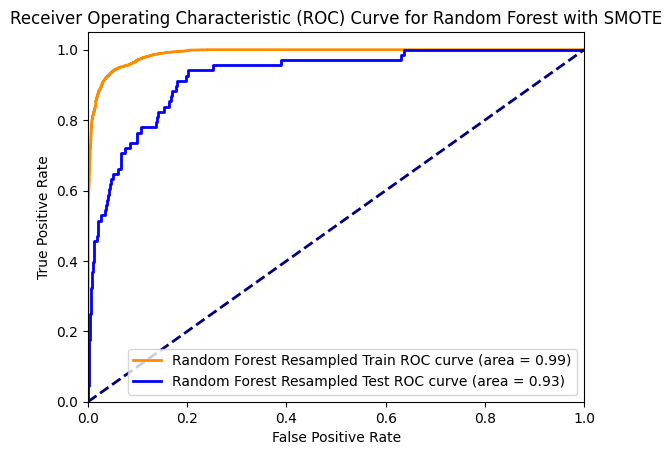

In [99]:
# Train the Random Forest model on the resampled data
rf_resampled = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced", min_samples_split=5, min_samples_leaf=10, max_depth=10)
rf_resampled.fit(X_train_resampled, Y_train_resampled)

# Compute ROC curve and ROC area for Random Forest on resampled data
fpr_rf_resampled_train, tpr_rf_resampled_train, _ = roc_curve(Y_train_resampled, rf_resampled.predict_proba(X_train_resampled)[:, 1])
roc_auc_rf_resampled_train = auc(fpr_rf_resampled_train, tpr_rf_resampled_train)

fpr_rf_resampled_test, tpr_rf_resampled_test, _ = roc_curve(Y_test, rf_resampled.predict_proba(X_test)[:, 1])
roc_auc_rf_resampled_test = auc(fpr_rf_resampled_test, tpr_rf_resampled_test)

# Plot ROC curves
plt.figure()

# Plot ROC for Random Forest on resampled data
plt.plot(fpr_rf_resampled_train, tpr_rf_resampled_train, color='darkorange', lw=2, label='Random Forest Resampled Train ROC curve (area = %0.2f)' % roc_auc_rf_resampled_train)
plt.plot(fpr_rf_resampled_test, tpr_rf_resampled_test, color='blue', lw=2, label='Random Forest Resampled Test ROC curve (area = %0.2f)' % roc_auc_rf_resampled_test)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest with SMOTE')
plt.legend(loc="lower right")
plt.show()

In [100]:
# Perform cross-validation on the SMOTE-resampled Random Forest model
cv_scores_rf_resampled = cross_val_score(rf_resampled, X, Y, cv=5, scoring='roc_auc')

# Print the cross-validation scores and the mean score
print("SMOTE-Resampled Random Forest Cross-Validation Scores: ", cv_scores_rf_resampled)
print("Mean Cross-Validation Score: ", cv_scores_rf_resampled.mean())

SMOTE-Resampled Random Forest Cross-Validation Scores:  [0.953641   0.9351632  0.62340915 0.79458957 0.9615531 ]
Mean Cross-Validation Score:  0.8536712039816493
